In [1]:
## Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Set path
import os
os.chdir('/content/drive/MyDrive/ADM/Homework V/Data')

In [1]:
## Import Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, date
import pickle

In [2]:
## Load Data
with open('sx-stackoverflow-a2q.txt') as f:
    a2q = f.readlines()

In [3]:
## Load Data
with open('sx-stackoverflow-c2q.txt') as f:
    c2q = f.readlines()

In [4]:
## Load Data
with open('sx-stackoverflow-c2a.txt') as f:
    c2a = f.readlines()

In [5]:
## Init Graph
G = nx.DiGraph()

In [6]:
len(a2q)

17823525

In [7]:
## Merge Graph
t_start = datetime(2009, 10, 1)
t_end = datetime(2010, 10, 1)

for line in a2q:
    line = line.replace('\n', '')
    line = line.split(' ') 
    t = datetime.fromtimestamp(int(line[2]))
    t_truncated = date(t.year,t.month, t.day)
    if t_start <= t < t_end :
        if G.has_edge(line[0], line[1]) :
            G[line[0]][line[1]]['weight'] += 0.6
            G[line[0]][line[1]]['timestamp'].append(t_truncated)
        else :
            G.add_edge(line[0], line[1], weight=0.6)
            G[line[0]][line[1]]['timestamp']=[t_truncated]
            
for line in c2q:
    line = line.replace('\n', '')
    line = line.split(' ') 
    t = datetime.fromtimestamp(int(line[2]))
    t_truncated = date(t.year,t.month, t.day)
    if t_start <= t < t_end :
        if G.has_edge(line[0], line[1]) :
            G[line[0]][line[1]]['weight'] += 0.3
            G[line[0]][line[1]]['timestamp'].append(t_truncated)
        else :
            G.add_edge(line[0], line[1], weight=0.3)
            G[line[0]][line[1]]['timestamp']=[t_truncated]

for line in c2a:
    line = line.replace('\n', '')
    line = line.split(' ') 
    t = datetime.fromtimestamp(int(line[2]))
    t_truncated = date(t.year,t.month, t.day)
    if t_start <= t < t_end :
        if G.has_edge(line[0], line[1]) :
            G[line[0]][line[1]]['weight'] += 0.1
            G[line[0]][line[1]]['timestamp'].append(t_truncated)
        else :
            G.add_edge(line[0], line[1], weight=0.1)
            G[line[0]][line[1]]['timestamp']=[t_truncated]

1
1


In [13]:
with open('G.pkl', 'wb') as f:
    pickle.dump(G, f)

### Functionality 4

In [2]:
with open('G.pkl', 'rb') as f:
    G = pickle.load(f)

In [3]:
def BFS(G, source, target, parent):

    visited ={key: False for key in nx.nodes(G)}
    queue=[]
    queue.append(source)
    visited[source] = True

    # Standard BFS Loop
    while queue:
        u = queue.pop(0)

        for ind in G[u]:
            if (visited[ind] == False) and (G[u][ind]['weight'] > 0) :
                queue.append(ind)
                visited[ind] = True
                parent[ind] = u

    return visited[target] #boolean

def dfs(G,s,visited):
    visited[s]=True
    for node in G[s]:
        if G[s][node]["weight"] > 0 and not visited[node]:
            dfs(G,node,visited)


In [4]:
def func4(int1_start, int1_end, int2_start, int2_end, user1, user2):
    """
    input:
    - Two different intervals of time (disjoint or not)
    - Two users which are unique to each interval of time 
        - user_1 only appears in interval 1
        - user_2 only appears in interval 2)
        
    output :
    - Minimum number of links (considering their weights) required to disconnect the two graphs.
    """
    
    #create the subgraph
    subG = nx.DiGraph()
    
    #add egdes/nodes if it belongs to one of the intervals of time 
    for edge in list(G.edges):
        if (int1_start <= G.edges[edge[0], edge[1]]['timestamp'][0] < int1_end) or (int2_start <= G.edges[edge[0], edge[1]]['timestamp'][0] < int2_end):
            subG.add_edge(edge[0], edge[1])
            subG[edge[0]][edge[1]]['weight'] = G.edges[edge[0], edge[1]]['weight']
            subG[edge[0]][edge[1]]['timestamp'] = G.edges[edge[0], edge[1]]['timestamp']

    subG_i=subG.copy()
    
    # This array is filled by BFS and to store path
    parent = {key: -1 for key in nx.nodes(G)}
    max_flow = 0 
    while BFS(subG, user1, user2, parent) :

        # Find minimum residual capacity of the edges along the
        # path filled by BFS. Or we can say find the maximum flow
        # through the path found.
        path_flow = float("Inf")
        s = user2
        while(s != user1):
            path_flow = min(path_flow, subG[parent[s]][s]["weight"])
            s = parent[s]

        # Add path flow to overall flow
        max_flow += path_flow

        # update residual capacities of the edges and reverse edges
        # along the path
        v = user2
        while(v != user1):
            u = parent[v]
            subG[u][v]["weight"] -= path_flow
            #g[v][u]["weight"] += path_flow
            v = parent[v]

    visited ={key: False for key in nx.nodes(subG)}
    dfs(subG,s,visited)

    # print the edges which initially had weights
    # but now have 0 weight
    count = 0
    edge_to_remove = []
    for i in nx.nodes(subG):
        for j in subG[i]:
            if (subG[i][j]["weight"] == 0) and (visited[i]):
                print(str(i) + " - " + str(j))
                edge_to_remove.append((i, j))
                count+=1
    print(count)
    
    return edge_to_remove, subG_i, count

In [198]:
int1_start = date(2010, 1, 1)
int1_end = date(2010, 1, 2)

int2_start = date(2010, 9, 1)
int2_end = date(2010, 9, 2)

user1 = '19068'
user2 = '399510'

edge_to_remove, subG_i, count = func4(int1_start, int1_end, int2_start, int2_end, user1, user2)

19068 - 102529
19068 - 411247
19068 - 282000
408089 - 361427
4


In [199]:
edge_to_remove

[('19068', '102529'),
 ('19068', '411247'),
 ('19068', '282000'),
 ('408089', '361427')]

## Not sure that it is correct So i did an easier test 

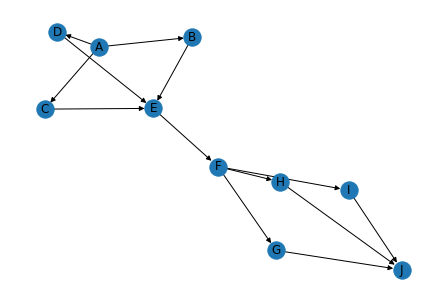

In [10]:
g=nx.DiGraph()
g.add_edge('A','B', weight=1)
g.add_edge('A','C', weight=1)
g.add_edge('A','D', weight=1)
g.add_edge('B','E', weight=1)
g.add_edge('C','E', weight=1)
g.add_edge('D','E', weight=1)
g.add_edge('E','F', weight=1)
g.add_edge('F','G', weight=1)
g.add_edge('F','H', weight=1)
g.add_edge('F','I', weight=1)
g.add_edge('G','J', weight=1)
g.add_edge('H','J', weight=1)
g.add_edge('I','J', weight=1)

plt.clf()
nx.draw(g, with_labels=True)
plt.show()

In [11]:
# This array is filled by BFS and to store path
user1 = 'A'
user2 = 'J'
g_i = g.copy()
parent = {key: -1 for key in nx.nodes(g)}
max_flow = 0 
while BFS(g, user1, user2, parent) :
    # Find minimum residual capacity of the edges along the
    # path filled by BFS. Or we can say find the maximum flow
    # through the path found.
    path_flow = float("Inf")
    s = user2
    while(s != user1):
        path_flow = min(path_flow, g[parent[s]][s]["weight"])
        s = parent[s]
    # Add path flow to overall flow
    max_flow += path_flow

    # update residual capacities of the edges and reverse edges
    # along the path
    v = user2 
    
    while(v != user1):
        u = parent[v]
        g[u][v]['weight'] = max(0, g[u][v]['weight'] - path_flow)
            
        if not g.has_edge(v,u) :
            g.add_edge(v,u) 
            g[v][u]["weight"] = 0
        g[v][u]["weight"] += path_flow
        
        v = parent[v]

visited ={key: False for key in nx.nodes(g)}
dfs(g,user1,visited)

# print the edges which initially had weights
# but now have 0 weight
for i in nx.nodes(g):
    for j in g[i] :
        if (g[i][j]["weight"] == 0)  and (g_i[i][j]["weight"] > 0) and (visited[i]):
            print(str(i) + " - " + str(j))


A - B
B - E
E - F


## only E-F is expected but two others are returned (A-B and B-E)

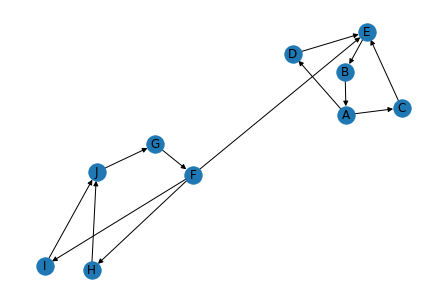

In [366]:
plt.clf()
nx.draw(g, with_labels=True)
plt.show()